In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split

import sys
sys.path.append('..')

from src.data.loader import get_data_loader
from src.models.lstm_model import BiLSTMModel
from src.evaluation.metrics import MetricsCalculator
from src.utils.persistence import ModelPersistence

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
loader = get_data_loader(mode='file', data_dir='../data')
train_df, y_labels = loader.load_train_data()

print(f"Training samples: {len(train_df)}")
print(f"Label columns: {list(y_labels.columns)}")
print("\nFirst few rows:")
train_df.head()

Training samples: 159571
Label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

First few rows:


,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


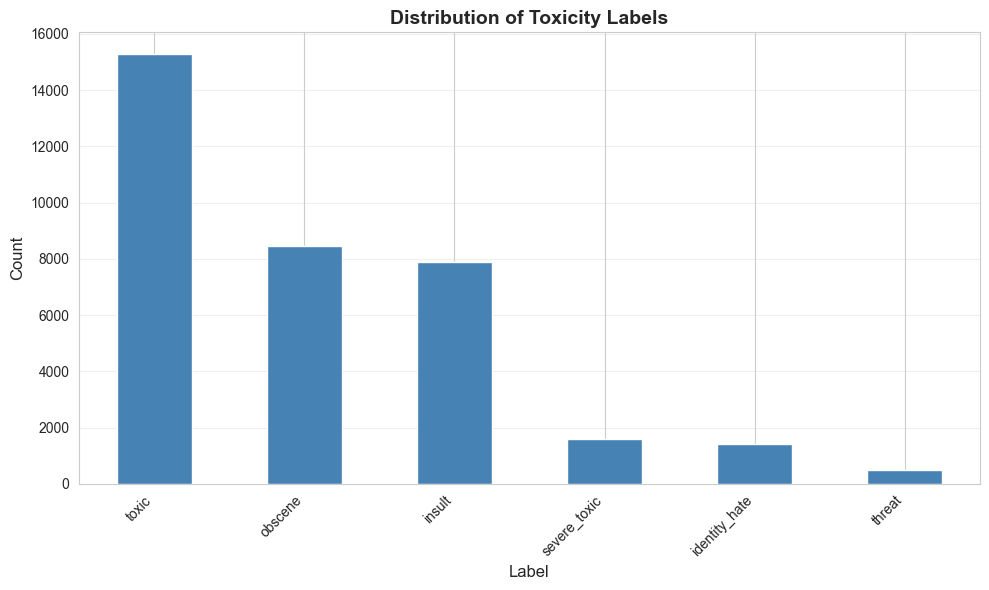


Label Statistics:
toxic          :  15294 ( 9.58%)
severe_toxic   :   1595 ( 1.00%)
obscene        :   8449 ( 5.29%)
threat         :    478 ( 0.30%)
insult         :   7877 ( 4.94%)
identity_hate  :   1405 ( 0.88%)


In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = y_labels[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='steelblue')
plt.title('Distribution of Toxicity Labels', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../report/figures/label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLabel Statistics:")
for label in label_cols:
    count = y_labels[label].sum()
    percentage = (count / len(train_df)) * 100
    print(f"{label:15s}: {count:6d} ({percentage:5.2f}%)")

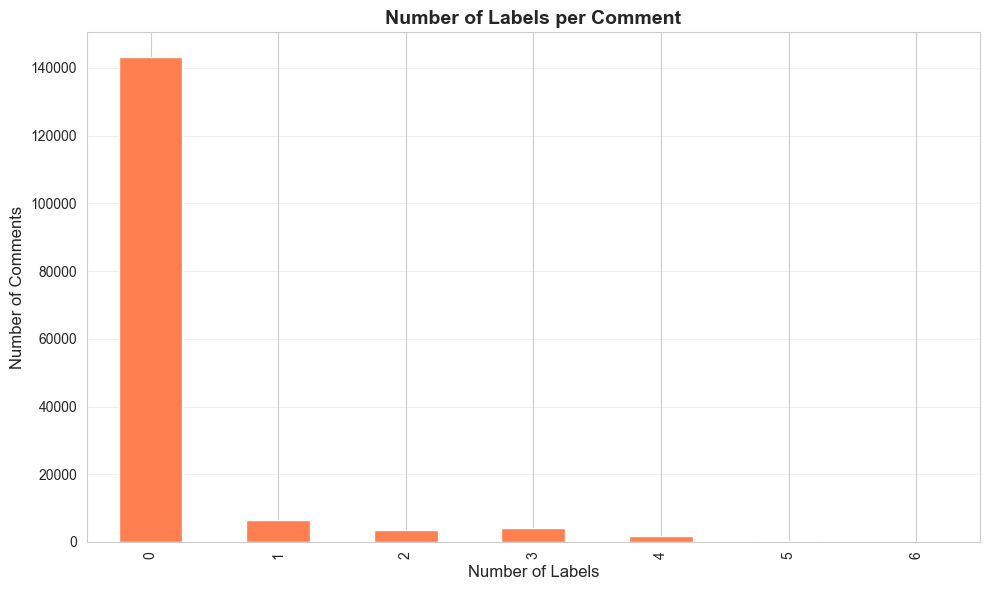


Multi-Label Statistics:
0 label(s): 143346 comments (89.83%)
1 label(s):   6360 comments ( 3.99%)
2 label(s):   3480 comments ( 2.18%)
3 label(s):   4209 comments ( 2.64%)
4 label(s):   1760 comments ( 1.10%)
5 label(s):    385 comments ( 0.24%)
6 label(s):     31 comments ( 0.02%)


In [4]:
label_counts_per_comment = y_labels[label_cols].sum(axis=1)
multi_label_dist = label_counts_per_comment.value_counts().sort_index()

plt.figure(figsize=(10, 6))
multi_label_dist.plot(kind='bar', color='coral')
plt.title('Number of Labels per Comment', fontsize=14, fontweight='bold')
plt.xlabel('Number of Labels', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../report/figures/multilabel_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMulti-Label Statistics:")
for num_labels, count in multi_label_dist.items():
    percentage = (count / len(train_df)) * 100
    print(f"{num_labels} label(s): {count:6d} comments ({percentage:5.2f}%)")

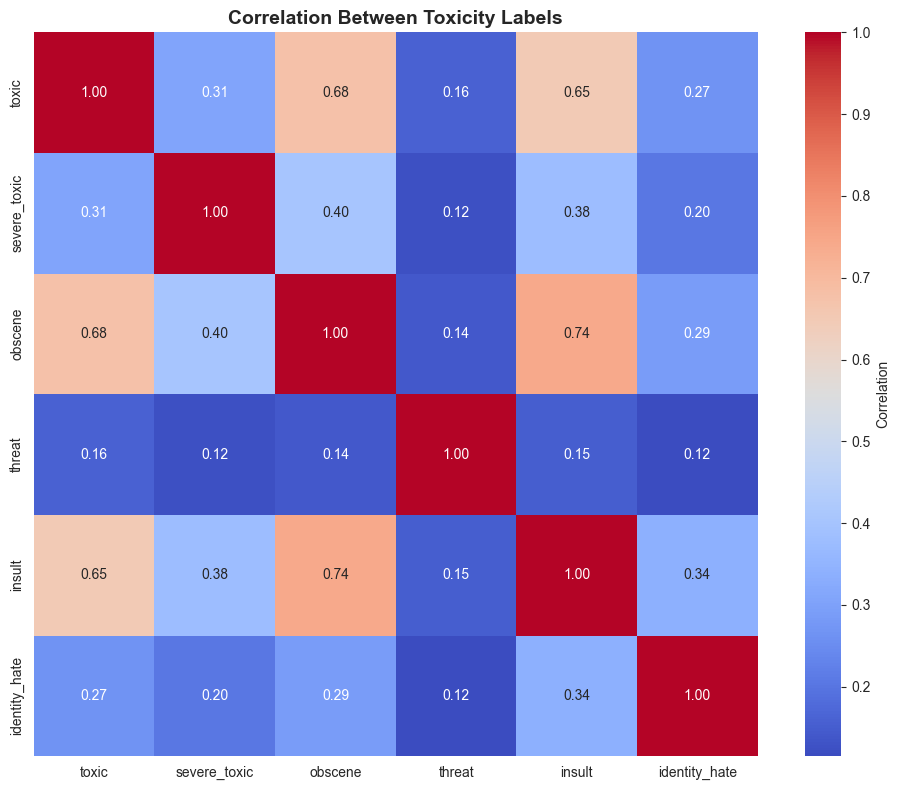


Strongest Correlations:
obscene - insult: 0.741
toxic - obscene: 0.677
toxic - insult: 0.648
severe_toxic - obscene: 0.403
severe_toxic - insult: 0.376


In [5]:
correlation_matrix = y_labels[label_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Between Toxicity Labels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../report/figures/label_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nStrongest Correlations:")
corr_pairs = []
for i in range(len(label_cols)):
    for j in range(i+1, len(label_cols)):
        corr_pairs.append((label_cols[i], label_cols[j], correlation_matrix.iloc[i, j]))
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for label1, label2, corr in corr_pairs[:5]:
    print(f"{label1} - {label2}: {corr:.3f}")

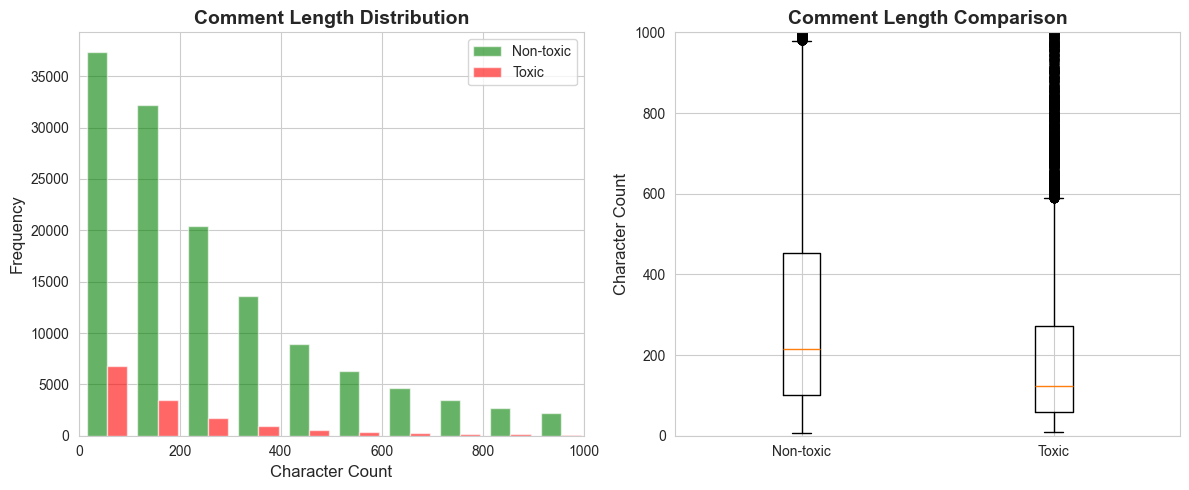


Length Statistics:
Non-toxic comments - Mean length: 404.5 chars
Toxic comments     - Mean length: 295.2 chars


In [6]:
train_df['comment_length'] = train_df['comment_text'].str.len()
train_df['word_count'] = train_df['comment_text'].str.split().str.len()

toxic_lengths = train_df[y_labels['toxic'] == 1]['comment_length']
non_toxic_lengths = train_df[y_labels['toxic'] == 0]['comment_length']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist([non_toxic_lengths, toxic_lengths], bins=50, label=['Non-toxic', 'Toxic'], 
         color=['green', 'red'], alpha=0.6)
plt.xlabel('Character Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Comment Length Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.xlim(0, 1000)

plt.subplot(1, 2, 2)
data_to_plot = [non_toxic_lengths, toxic_lengths]
plt.boxplot(data_to_plot, labels=['Non-toxic', 'Toxic'])
plt.ylabel('Character Count', fontsize=12)
plt.title('Comment Length Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 1000)

plt.tight_layout()
plt.savefig('../report/figures/length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLength Statistics:")
print(f"Non-toxic comments - Mean length: {non_toxic_lengths.mean():.1f} chars")
print(f"Toxic comments     - Mean length: {toxic_lengths.mean():.1f} chars")

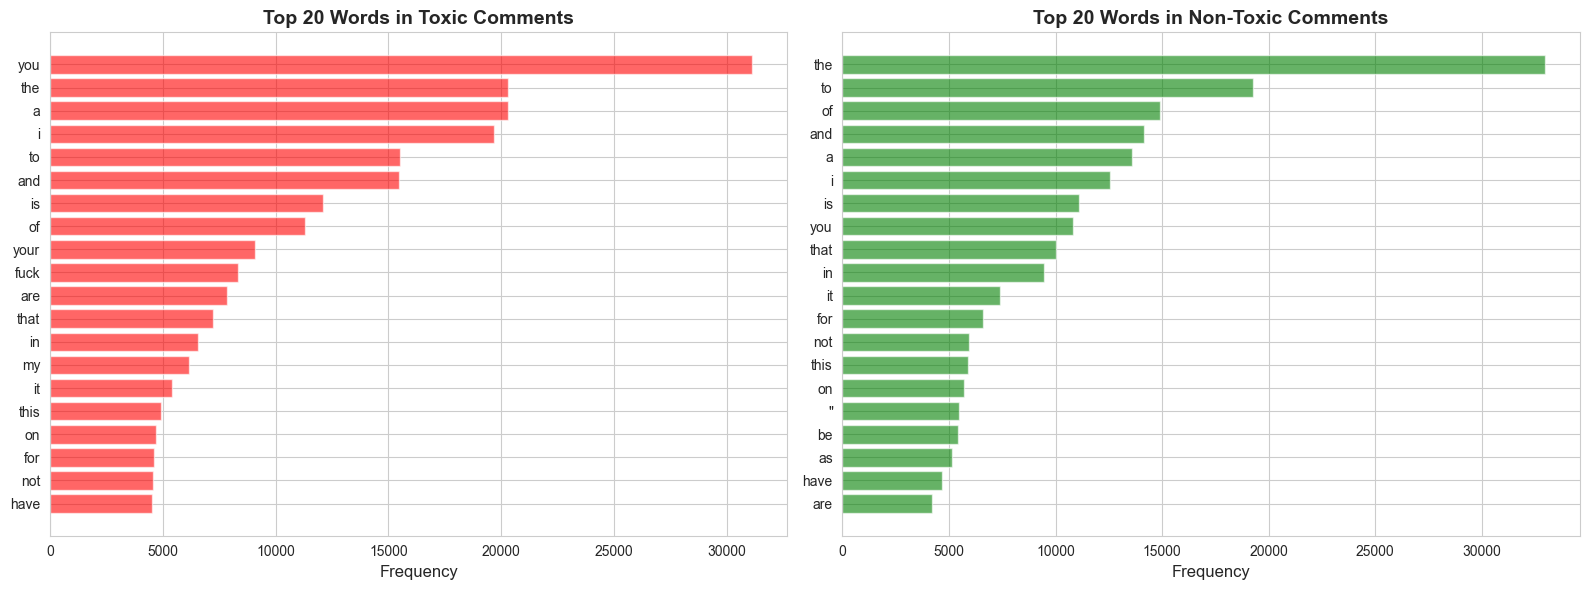

In [7]:
toxic_texts = ' '.join(train_df[y_labels['toxic'] == 1]['comment_text'].astype(str))
toxic_words = toxic_texts.lower().split()
toxic_word_freq = Counter(toxic_words).most_common(20)

non_toxic_texts = ' '.join(train_df[y_labels['toxic'] == 0]['comment_text'].head(10000).astype(str))
non_toxic_words = non_toxic_texts.lower().split()
non_toxic_word_freq = Counter(non_toxic_words).most_common(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

words1, counts1 = zip(*toxic_word_freq)
ax1.barh(range(len(words1)), counts1, color='red', alpha=0.6)
ax1.set_yticks(range(len(words1)))
ax1.set_yticklabels(words1)
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_title('Top 20 Words in Toxic Comments', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

words2, counts2 = zip(*non_toxic_word_freq)
ax2.barh(range(len(words2)), counts2, color='green', alpha=0.6)
ax2.set_yticks(range(len(words2)))
ax2.set_yticklabels(words2)
ax2.set_xlabel('Frequency', fontsize=12)
ax2.set_title('Top 20 Words in Non-Toxic Comments', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../report/figures/word_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
MAX_FEATURES = 3000
MAX_SEQUENCE = 100
EMBEDDING_DIM = 32
LSTM_UNITS = 32
NUM_EPOCHS = 5
BATCH_SIZE = 32
NUM_FOLDS = 10

print("Model Configuration:")
print(f"  Vocabulary size: {MAX_FEATURES:,} tokens")
print(f"  Sequence length: {MAX_SEQUENCE}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  LSTM units: {LSTM_UNITS} per direction ({LSTM_UNITS*2} total)")
print(f"\nTraining Configuration:")
print(f"  K-Fold splits: {NUM_FOLDS}")
print(f"  Epochs per fold: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")

Model Configuration:
  Vocabulary size: 3,000 tokens
  Sequence length: 100
  Embedding dimension: 32
  LSTM units: 32 per direction (64 total)

Training Configuration:
  K-Fold splits: 10
  Epochs per fold: 5
  Batch size: 32


In [9]:
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
evaluator = MetricsCalculator()
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df), 1):
    print(f"\n{'='*80}")
    print(f"FOLD {fold}/{NUM_FOLDS}")
    print(f"{'='*80}")
    
    X_train_fold = train_df.iloc[train_idx]['comment_text']
    y_train_fold = y_labels.iloc[train_idx]
    X_val_fold = train_df.iloc[val_idx]['comment_text']
    y_val_fold = y_labels.iloc[val_idx]
    
    print(f"Training samples: {len(X_train_fold):,}")
    print(f"Validation samples: {len(X_val_fold):,}")
    
    model = BiLSTMModel(
        max_features=MAX_FEATURES,
        max_len=MAX_SEQUENCE,
        embedding_dim=EMBEDDING_DIM,
        lstm_units=LSTM_UNITS
    )
    
    print(f"\nTraining fold {fold}...")
    model.fit(
        X_train_fold, 
        y_train_fold,
        X_val=X_val_fold,
        y_val=y_val_fold,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    print(f"\nEvaluating fold {fold}...")
    y_pred = model.predict(X_val_fold)
    metrics = evaluator.calculate_metrics(y_val_fold.values, y_pred)
    fold_metrics.append(metrics)
    
    print(f"\nFold {fold} Results:")
    print(f"  Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")


FOLD 1/10
Training samples: 143,613
Validation samples: 15,958

Training fold 1...
Epoch 1/5
4488/4488 [==============================] - 116s 25ms/step - loss: 0.0705 - accuracy: 0.9434 - val_loss: 0.0544 - val_accuracy: 0.9940
Epoch 2/5
4488/4488 [==============================] - 106s 24ms/step - loss: 0.0560 - accuracy: 0.9863 - val_loss: 0.0540 - val_accuracy: 0.9940
Epoch 3/5
4488/4488 [==============================] - 115s 26ms/step - loss: 0.0527 - accuracy: 0.9904 - val_loss: 0.0541 - val_accuracy: 0.9940
Epoch 4/5
4488/4488 [==============================] - 131s 29ms/step - loss: 0.0499 - accuracy: 0.9892 - val_loss: 0.0534 - val_accuracy: 0.9940
Epoch 5/5
4488/4488 [==============================] - 127s 28ms/step - loss: 0.0472 - accuracy: 0.9917 - val_loss: 0.0548 - val_accuracy: 0.9940

Evaluating fold 1...
499/499 [==============================] - 5s 6ms/step

Fold 1 Results:
  Hamming Loss: 0.0184
  F1 Score: 0.6962
  Precision: 0.7443
  Recall: 0.6624
  Accuracy: 0

In [10]:
mean_metrics = {}
std_metrics = {}
for metric in fold_metrics[0].keys():
    values = [fold[metric] for fold in fold_metrics]
    mean_metrics[metric] = np.mean(values)
    std_metrics[metric] = np.std(values)

print("\nFINAL RESULTS - 10-Fold Cross-Validation")
print("="*80)
print("\nMean ± Standard Deviation:")
for metric in mean_metrics.keys():
    print(f"  {metric:20s}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")


FINAL RESULTS - 10-Fold Cross-Validation

Mean ± Standard Deviation:
  accuracy            : 0.9166 ± 0.0023
  precision           : 0.7777 ± 0.0267
  recall              : 0.6344 ± 0.0263
  f1_score            : 0.6877 ± 0.0103
  hamming_loss        : 0.0190 ± 0.0005
  roc_auc             : 0.9655 ± 0.0018


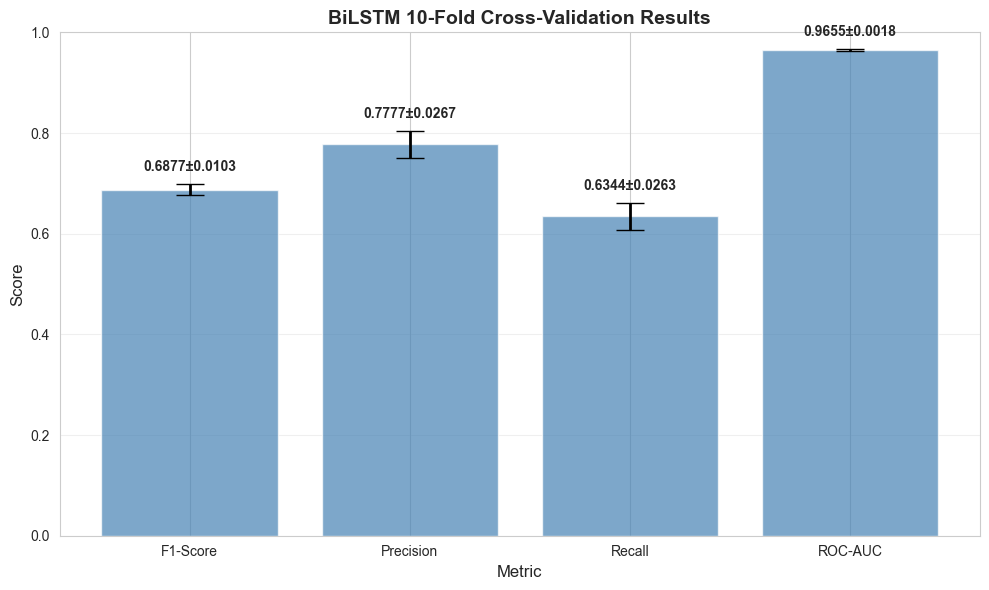

In [11]:
metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']
means = [mean_metrics['f1_score'], mean_metrics['precision'], mean_metrics['recall'], mean_metrics['roc_auc']]
stds = [std_metrics['f1_score'], std_metrics['precision'], std_metrics['recall'], std_metrics['roc_auc']]

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(metrics))
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.7, 
       color='steelblue', capsize=10, error_kw={'linewidth': 2})
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.set_title('BiLSTM 10-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 0.02, f'{mean:.4f}±{std:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../report/figures/cv_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
final_model = BiLSTMModel(
    max_features=MAX_FEATURES,
    max_len=MAX_SEQUENCE,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS
)

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    train_df['comment_text'], y_labels, test_size=0.2, random_state=42
)

print(f"Training final model on {len(X_train_final):,} samples...")
print(f"Validation on {len(X_val_final):,} samples...")

final_model.fit(
    X_train_final,
    y_train_final,
    X_val=X_val_final,
    y_val=y_val_final,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

print("\nSaving final model...")
ModelPersistence.create_model_directory('../models')
ModelPersistence.save_model_with_metadata(final_model, '../models/bilstm_toxic_classifier.keras')
print("Model saved to: ../models/bilstm_toxic_classifier.keras")

Training final model on 127,656 samples...
Validation on 31,915 samples...
Epoch 1/5
3990/3990 [==============================] - 112s 27ms/step - loss: 0.0711 - accuracy: 0.9181 - val_loss: 0.0562 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - 102s 26ms/step - loss: 0.0557 - accuracy: 0.9854 - val_loss: 0.0543 - val_accuracy: 0.9941
Epoch 3/5
3990/3990 [==============================] - 107s 27ms/step - loss: 0.0525 - accuracy: 0.9820 - val_loss: 0.0552 - val_accuracy: 0.9941
Epoch 4/5
3990/3990 [==============================] - 105s 26ms/step - loss: 0.0496 - accuracy: 0.9908 - val_loss: 0.0556 - val_accuracy: 0.9941
Epoch 5/5
3990/3990 [==============================] - 104s 26ms/step - loss: 0.0468 - accuracy: 0.9895 - val_loss: 0.0569 - val_accuracy: 0.9941

Saving final model...
Model saved to ../models/bilstm_toxic_classifier.keras
Metadata saved to ../models/bilstm_toxic_classifier_metadata.json
Model saved to: ../models/bilstm_toxic_classifier.k